In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import circle

In [2]:
n_samples = 10000
seq_len = 6

size = 16

X_train = []
Y_train = []

for _ in range(n_samples):

    i,j = np.random.randint(0, size+1, size=2)    
    vi, vj = np.random.randint(-3, 3, size=2)
    
    sequence = np.zeros((seq_len, size, size, 1))
    
    for step in range(seq_len):
        
        i, j = i+vi, j+vj
        
        if i >= size: 
            i = size-1
            vi *= -1
        if i < 0:
            i = 0
            vi *= -1
        if j >= size: 
            j = size-1
            vj *= -1
        if j < 0:
            j = 0
            vj *= -1        
        
        sequence[step, i, j, 0] = 1
        rr,cc = circle(i,j, 2)
        rr = np.clip(rr, 0, size-1)
        cc = np.clip(cc, 0, size-1)
        sequence[step, rr, cc] = 1
        
    X_train.append(sequence[:-1])
    Y_train.append(sequence[-1])
    
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

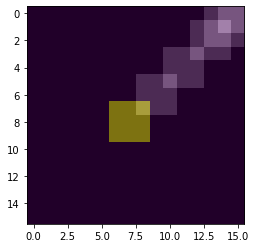

In [3]:
idx = np.random.randint(100)
seq = X_train[idx,:,:,:]
pred = Y_train[idx]

plt.imshow(np.sum(seq, axis=0)[:,:,0], cmap="gray")
plt.imshow(pred[:,:,0], alpha=0.5)

In [6]:
import keras

In [7]:
X_train.shape

(10000, 5, 16, 16, 1)

In [15]:
from keras.layers import TimeDistributed

model = keras.models.Sequential()                                                        # (None, Ts, 16, 16, 1)                                                                               

model.add(TimeDistributed(keras.layers.Conv2D(32, 5, padding="same", activation="relu"), # (None, Ts, 16, 16, 32) 
                                       input_shape=(seq_len-1, size, size, 1)))     
model.add(TimeDistributed(keras.layers.MaxPool2D((2, 2))))                               # (None, Ts,  8,  8, 32)  
model.add(TimeDistributed(keras.layers.Conv2D(64, 5, padding="same", activation="relu")))# (None, Ts,  8,  8, 64) 
model.add(TimeDistributed(keras.layers.MaxPool2D((2, 2))))                               # (None, Ts,  4,  4, 64) 
model.add(TimeDistributed(keras.layers.Flatten()))                                       # (None, Ts,     4*4*64) 
model.add(keras.layers.LSTM(64*20))                                                      # (None,          64*20) 
model.add(keras.layers.Reshape((8, 8, 20)))                                              # (None,      8,  8, 20) 
model.add(keras.layers.Conv2DTranspose(10, (5,5), strides=(2,2),                         # (None,     16, 16, 10)
                                       padding="same", activation="relu"))       
model.add(keras.layers.Conv2DTranspose(1, (5,5), strides=(1,1),                          # (None,     16, 16,  1)
                                       padding="same", activation="sigmoid"))

In [16]:
model.summary(line_length=100)

Model: "sequential_3"
____________________________________________________________________________________________________
Layer (type)                                 Output Shape                            Param #        
time_distributed_11 (TimeDistributed)        (None, 5, 16, 16, 32)                   832            
____________________________________________________________________________________________________
time_distributed_12 (TimeDistributed)        (None, 5, 8, 8, 32)                     0              
____________________________________________________________________________________________________
time_distributed_13 (TimeDistributed)        (None, 5, 8, 8, 64)                     51264          
____________________________________________________________________________________________________
time_distributed_14 (TimeDistributed)        (None, 5, 4, 4, 64)                     0              
_____________________________________________________________________

In [ ]:
model.compile(keras.optimizers.Adam(0.0002), "binary_crossentropy")

In [ ]:
model.fit(X_train, Y_train, epochs=200, batch_size=32)

In [ ]:
seq = X_train[np.random.randint(100),:,:,:]
pred = model.predict(np.asarray([seq]))[0]

plt.imshow(np.sum(seq, axis=0)[:,:,0], cmap="gray")
plt.imshow(pred[:,:,0], alpha=0.5)